In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, SequentialSampler

### Test the dataloader

In [2]:
from data_loader import ts_dataset

In [3]:
# create the dataframe
total_size = 18
np_x = np.arange(3 * total_size).reshape(total_size, 3, order='F')
print(np_x)
df = pd.DataFrame(np_x, columns=['a', 'b', 'c'])
print(df)

[[ 0 18 36]
 [ 1 19 37]
 [ 2 20 38]
 [ 3 21 39]
 [ 4 22 40]
 [ 5 23 41]
 [ 6 24 42]
 [ 7 25 43]
 [ 8 26 44]
 [ 9 27 45]
 [10 28 46]
 [11 29 47]
 [12 30 48]
 [13 31 49]
 [14 32 50]
 [15 33 51]
 [16 34 52]
 [17 35 53]]
     a   b   c
0    0  18  36
1    1  19  37
2    2  20  38
3    3  21  39
4    4  22  40
5    5  23  41
6    6  24  42
7    7  25  43
8    8  26  44
9    9  27  45
10  10  28  46
11  11  29  47
12  12  30  48
13  13  31  49
14  14  32  50
15  15  33  51
16  16  34  52
17  17  35  53


In [4]:
seq_len = 3
pred_len = 2
scale = False
inverse = True

In [5]:
train_dataset = ts_dataset(df, seq_len, pred_len, 'train', ['b', 'c'], scale=scale, inverse=inverse)
print(len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=10, 
                              sampler=SequentialSampler(train_dataset), drop_last=False)
for i, (x, y) in enumerate(train_dataloader):
    print(x.shape)
    print(x)
    print(y.shape)
    print(y)

8
torch.Size([8, 3, 3])
tensor([[[ 0., 18., 36.],
         [ 1., 19., 37.],
         [ 2., 20., 38.]],

        [[ 1., 19., 37.],
         [ 2., 20., 38.],
         [ 3., 21., 39.]],

        [[ 2., 20., 38.],
         [ 3., 21., 39.],
         [ 4., 22., 40.]],

        [[ 3., 21., 39.],
         [ 4., 22., 40.],
         [ 5., 23., 41.]],

        [[ 4., 22., 40.],
         [ 5., 23., 41.],
         [ 6., 24., 42.]],

        [[ 5., 23., 41.],
         [ 6., 24., 42.],
         [ 7., 25., 43.]],

        [[ 6., 24., 42.],
         [ 7., 25., 43.],
         [ 8., 26., 44.]],

        [[ 7., 25., 43.],
         [ 8., 26., 44.],
         [ 9., 27., 45.]]])
torch.Size([8, 2, 2])
tensor([[[21., 39.],
         [22., 40.]],

        [[22., 40.],
         [23., 41.]],

        [[23., 41.],
         [24., 42.]],

        [[24., 42.],
         [25., 43.]],

        [[25., 43.],
         [26., 44.]],

        [[26., 44.],
         [27., 45.]],

        [[27., 45.],
         [28., 46.]],

      

In [6]:
train_dataset = ts_dataset(df, seq_len, pred_len, 'val', ['b', 'c'], scale=scale, inverse=inverse)
print(len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=10, 
                              sampler=SequentialSampler(train_dataset), drop_last=False)
for i, (x, y) in enumerate(train_dataloader):
    print(x.shape)
    print(x)
    print(y.shape)
    print(y)

3
torch.Size([3, 3, 3])
tensor([[[ 8., 26., 44.],
         [ 9., 27., 45.],
         [10., 28., 46.]],

        [[ 9., 27., 45.],
         [10., 28., 46.],
         [11., 29., 47.]],

        [[10., 28., 46.],
         [11., 29., 47.],
         [12., 30., 48.]]])
torch.Size([3, 2, 2])
tensor([[[29., 47.],
         [30., 48.]],

        [[30., 48.],
         [31., 49.]],

        [[31., 49.],
         [32., 50.]]])


In [7]:
train_dataset = ts_dataset(df, seq_len, pred_len, 'test', ['b', 'c'], scale=scale, inverse=inverse)
print(len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=10, 
                              sampler=SequentialSampler(train_dataset), drop_last=False)
for i, (x, y) in enumerate(train_dataloader):
    print(x.shape)
    print(x)
    print(y.shape)
    print(y)

3
torch.Size([3, 3, 3])
tensor([[[11., 29., 47.],
         [12., 30., 48.],
         [13., 31., 49.]],

        [[12., 30., 48.],
         [13., 31., 49.],
         [14., 32., 50.]],

        [[13., 31., 49.],
         [14., 32., 50.],
         [15., 33., 51.]]])
torch.Size([3, 2, 2])
tensor([[[32., 50.],
         [33., 51.]],

        [[33., 51.],
         [34., 52.]],

        [[34., 52.],
         [35., 53.]]])


### Test the VAR model

In [8]:
# Generate time index
dates = pd.date_range('2020-01-01', periods=500)

# 2. Linear trend + noise
linear_trend1 = 0.1 * np.arange(500) + np.random.normal(0, 2, 500)
linear_trend2 = 0.2 * np.arange(500) + np.random.normal(0, 1, 500)
linear_trend3 = 0.3 * np.arange(500) + np.random.normal(0, 2, 500)

non_stationary_df = pd.DataFrame(np.concatenate([np.expand_dims(linear_trend1, 1), np.expand_dims(linear_trend2, 1), 
           np.expand_dims(linear_trend3, 1)], axis=1), 
           index=dates, columns=['a', 'b', 'c'])

In [9]:
print(non_stationary_df)

                    a           b           c
2020-01-01   2.465633   -1.409026   -2.338717
2020-01-02   0.213080    0.800725    4.573405
2020-01-03   1.245783    0.052015    2.313238
2020-01-04   0.745776    2.126372    0.590731
2020-01-05  -1.579354   -0.410485    6.179510
...               ...         ...         ...
2021-05-10  49.586653  100.920429  148.289048
2021-05-11  47.174954   98.137377  147.901438
2021-05-12  49.065457   99.914622  148.773310
2021-05-13  49.989214   98.150286  148.207722
2021-05-14  48.729706   98.850946  150.884076

[500 rows x 3 columns]


In [10]:
from autoregression import make_data_stationary

In [11]:
df = make_data_stationary(non_stationary_df)

Checking a:
ADF Statistic: -0.738462997657391
p-value: 0.8365336749184028
a is non-stationary - differencing required
Checking b:
ADF Statistic: 0.10881251989525491
p-value: 0.9666576407060758
b is non-stationary - differencing required
Checking c:
ADF Statistic: 0.1317387346399646
p-value: 0.9681624194513984
c is non-stationary - differencing required
ADF Statistic: -9.215162230574458
p-value: 1.842270710864472e-15
Checking differenced a, stationary: True
ADF Statistic: -9.482427404575686
p-value: 3.840945084934155e-16
Checking differenced b, stationary: True
ADF Statistic: -9.633671777410209
p-value: 1.587425650598397e-16
Checking differenced c, stationary: True


In [12]:
train_dataset = ts_dataset(df, 2, 1, 'train', ['a', 'b', 'c'], scale=True, inverse=True)
train_df = train_dataset.get_dataframe()

mean:  a    0.087920
b    0.208612
c    0.298122
dtype: float64
std:  a    2.790624
b    1.418042
c    2.822249
dtype: float64


In [13]:
from autoregression import fit_VAR
model = fit_VAR(train_df)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0     -0.02539    0.008471      0.9749    -0.01189
1      -0.9159     -0.7805      0.4002     -0.8619
2       -1.306     -1.069*      0.2710      -1.211
3       -1.391      -1.053      0.2487      -1.256
4       -1.484      -1.044      0.2268      -1.308
5       -1.596      -1.054      0.2028     -1.380*
6       -1.591     -0.9478      0.2038      -1.335
7       -1.624     -0.8787      0.1973      -1.327
8       -1.604     -0.7579      0.2012      -1.267
9       -1.628     -0.6800      0.1965      -1.250
10     -1.662*     -0.6124     0.1900*      -1.244
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Jun, 2025
Time:                     18:29:05
------------------------------------------------------------

In [14]:
from autoregression import diagnostics_checking

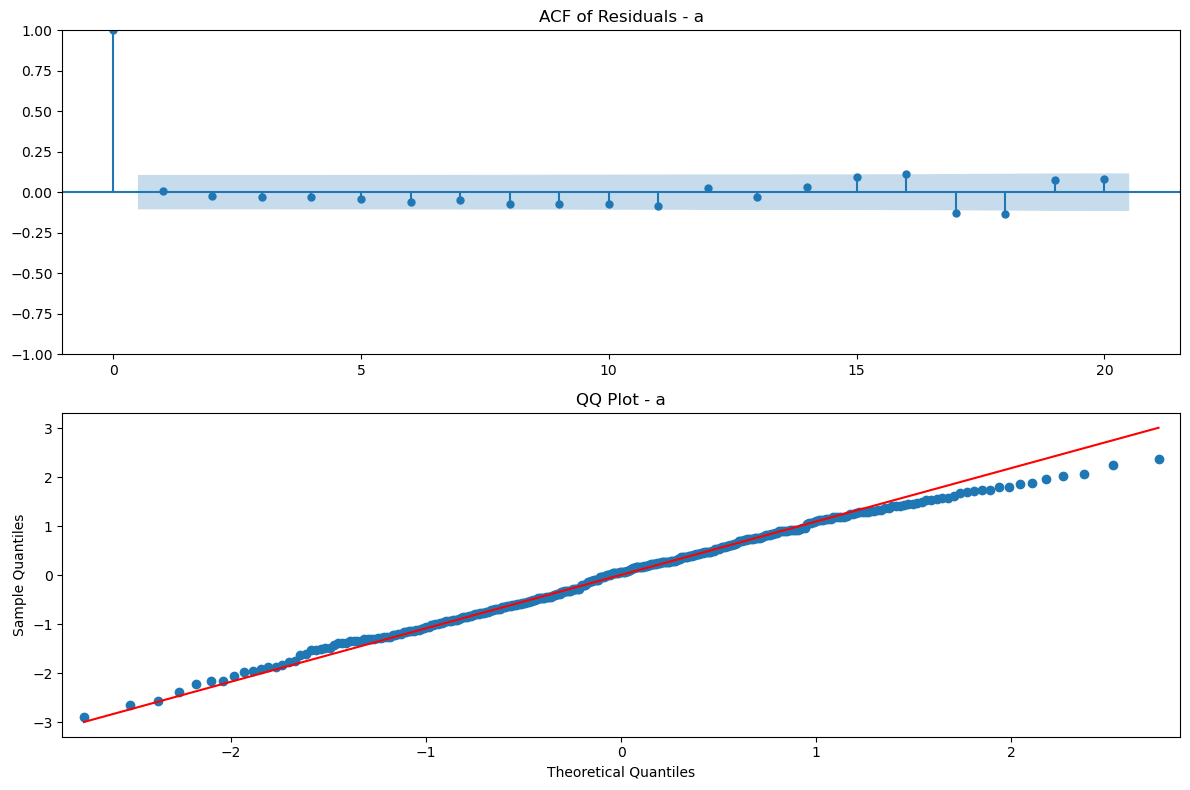

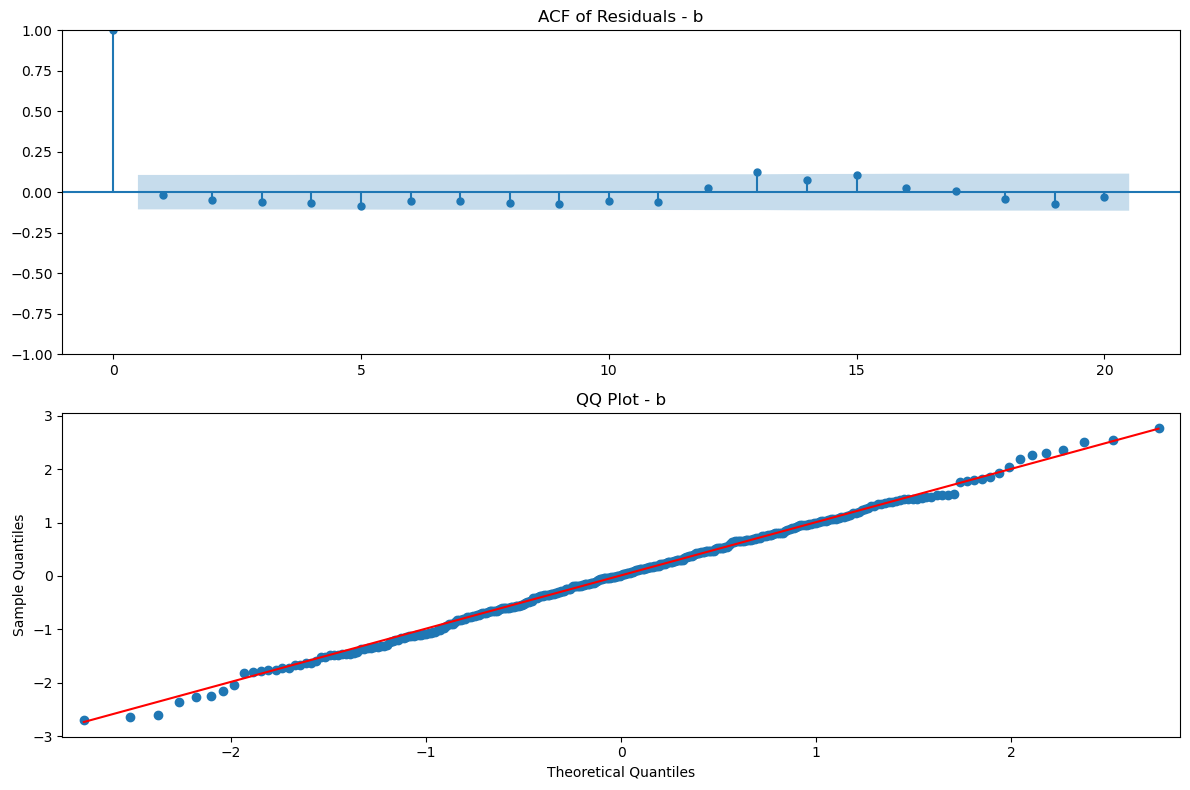

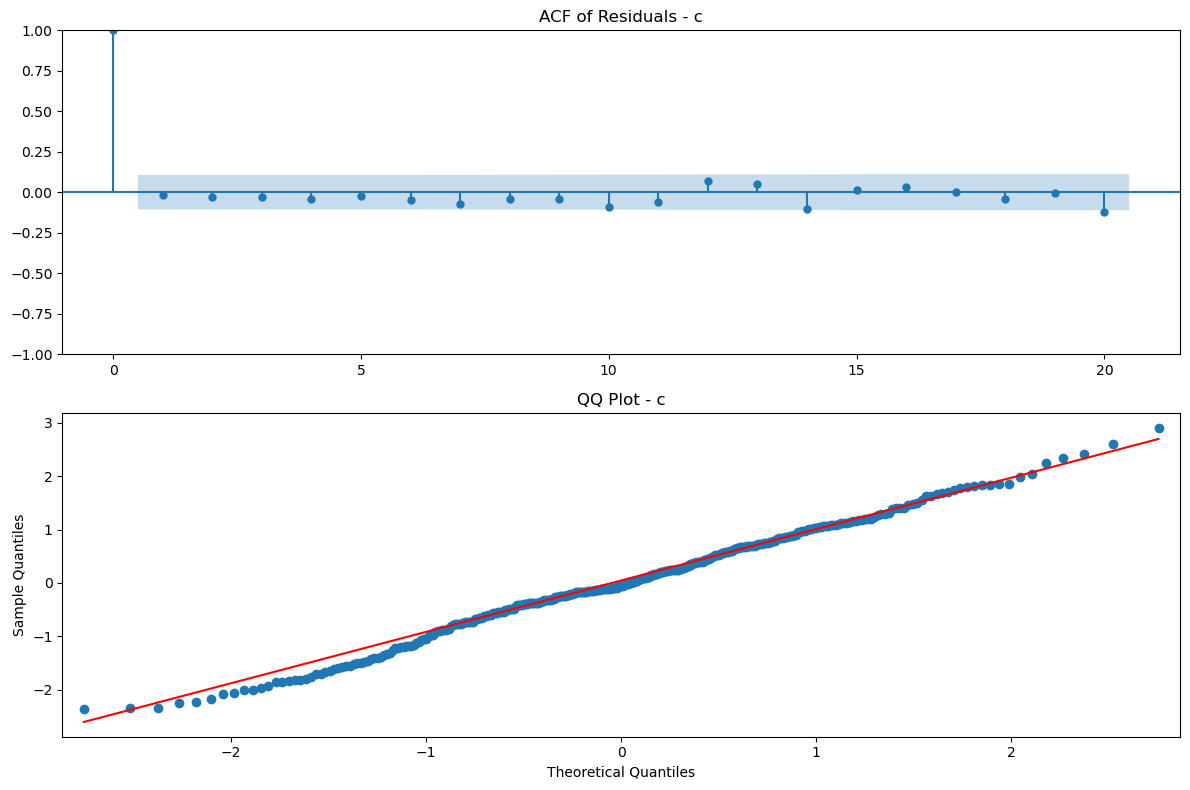


Ljung-Box Test Results:

a:
Lag 1: p-value = 0.0000 (significant)
Lag 2: p-value = 0.0000 (significant)
Lag 3: p-value = 0.0000 (significant)
Lag 4: p-value = 0.0000 (significant)
Lag 5: p-value = 0.0000 (significant)
Lag 6: p-value = 0.0000 (significant)
Lag 7: p-value = 0.0000 (significant)
Lag 8: p-value = 0.0000 (significant)
Lag 9: p-value = 0.0000 (significant)
Lag 10: p-value = 0.0000 (significant)
Lag 11: p-value = 0.0000 (significant)

b:
Lag 1: p-value = 0.0000 (significant)
Lag 2: p-value = 0.0000 (significant)
Lag 3: p-value = 0.0000 (significant)
Lag 4: p-value = 0.0000 (significant)
Lag 5: p-value = 0.0000 (significant)
Lag 6: p-value = 0.0000 (significant)
Lag 7: p-value = 0.0000 (significant)
Lag 8: p-value = 0.0000 (significant)
Lag 9: p-value = 0.0000 (significant)
Lag 10: p-value = 0.0000 (significant)
Lag 11: p-value = 0.0000 (significant)

c:
Lag 1: p-value = 0.0000 (significant)
Lag 2: p-value = 0.0000 (significant)
Lag 3: p-value = 0.0000 (significant)
Lag 4: p-

In [15]:
diagnostics_checking(model)

In [16]:
from autoregression import forecast

In [17]:
non_stationary_df

,a,b,c
2020-01-01,2.465633,-1.409026,-2.338717
2020-01-02,0.213080,0.800725,4.573405
2020-01-03,1.245783,0.052015,2.313238
2020-01-04,0.745776,2.126372,0.590731
2020-01-05,-1.579354,-0.410485,6.179510
...,...,...,...
2021-05-10,49.586653,100.920429,148.289048
2021-05-11,47.174954,98.137377,147.901438
2021-05-12,49.065457,99.914622,148.773310
2021-05-13,49.989214,98.150286,148.207722


In [18]:
df

,a,b,c
2020-01-02,-2.252554,2.209751,6.912122
2020-01-03,1.032703,-0.748709,-2.260167
2020-01-04,-0.500007,2.074357,-1.722507
2020-01-05,-2.325130,-2.536857,5.588779
2020-01-06,-0.776925,2.725927,-4.773820
...,...,...,...
2021-05-10,4.597563,0.236809,-1.622293
2021-05-11,-2.411699,-2.783052,-0.387611
2021-05-12,1.890503,1.777244,0.871872
2021-05-13,0.923757,-1.764336,-0.565588


In [19]:
val_dataset = ts_dataset(df, int(model.k_ar), 1, 'val', ['a', 'b', 'c'], scale=True, inverse=True)
val_df = val_dataset.get_dataframe()

test_dataset = ts_dataset(df, int(model.k_ar), 1, 'test', ['a', 'b', 'c'], scale=True, inverse=True)
test_df = test_dataset.get_dataframe()

test_df = pd.concat([val_df, test_df]).drop_duplicates()

mean:  a    0.087920
b    0.208612
c    0.298122
dtype: float64
std:  a    2.790624
b    1.418042
c    2.822249
dtype: float64
mean:  a    0.087920
b    0.208612
c    0.298122
dtype: float64
std:  a    2.790624
b    1.418042
c    2.822249
dtype: float64


In [20]:
print(test_df.shape)
print(test_df.head(10))
print(test_df.tail(10))

(160, 3)
                   a         b         c
2020-12-06  0.964119 -0.189208 -2.351287
2020-12-07 -1.131798  0.476567  1.150255
2020-12-08 -0.758076 -0.888483  0.437086
2020-12-09  0.547218  0.288066 -0.091197
2020-12-10 -2.103207 -0.542648  0.312033
2020-12-11  0.791736 -0.112857 -0.487354
2020-12-12  0.607136  1.905660 -0.833017
2020-12-13 -0.257564 -2.491326  0.971060
2020-12-14  1.237559  0.238211  0.252723
2020-12-15 -0.965413  1.858544 -1.534082
                   a         b         c
2021-05-05  1.191103  0.434969  0.078812
2021-05-06 -0.552579  0.004039 -0.660284
2021-05-07 -0.296688 -0.562068  0.668822
2021-05-08  0.188877  0.269166 -0.289924
2021-05-09 -1.475658  1.263905  0.376288
2021-05-10  1.615998  0.019884 -0.680456
2021-05-11 -0.895720 -2.109714 -0.242974
2021-05-12  0.645942  1.106195  0.203296
2021-05-13  0.299516 -1.391318 -0.306036
2021-05-14 -0.482841  0.346991  0.842673


In [21]:
non_stationary_test_df = non_stationary_df.loc[non_stationary_df.index.isin(test_df.index)]
print(non_stationary_test_df.shape)
print(non_stationary_test_df.head(10))
print(non_stationary_test_df.tail(10))

(160, 3)
                    a          b           c
2020-12-06  38.030220  68.481553   98.521629
2020-12-07  34.959717  69.365959  102.066057
2020-12-08  32.932132  68.314664  103.597745
2020-12-09  34.547131  68.931765  103.638487
2020-12-10  28.765790  68.370880  104.817242
2020-12-11  31.063148  68.419456  103.739930
2020-12-12  32.845356  71.330375  101.687071
2020-12-13  32.214512  68.006181  104.725765
2020-12-14  35.755994  68.552587  105.737132
2020-12-15  33.149811  71.396695  101.705693
                    a           b           c
2021-05-05  50.598315   98.466518  148.451018
2021-05-06  49.144196   98.680858  146.885653
2021-05-07  48.404171   98.092434  149.071358
2021-05-08  49.019176   98.682736  148.551242
2021-05-09  44.989090  100.683620  149.911342
2021-05-10  49.586653  100.920429  148.289048
2021-05-11  47.174954   98.137377  147.901438
2021-05-12  49.065457   99.914622  148.773310
2021-05-13  49.989214   98.150286  148.207722
2021-05-14  48.729706   98.850946  1

In [22]:
print(non_stationary_test_df.shape)

(160, 3)


In [23]:
non_stationary_test_df.head(2)

,a,b,c
2020-12-06,38.030220,68.481553,98.521629
2020-12-07,34.959717,69.365959,102.066057


Checking a:
ADF Statistic: -0.5327547915472868
p-value: 0.8854645819849267
a is non-stationary - differencing required
Checking b:
ADF Statistic: 0.546105512728429
p-value: 0.9862090769407745
b is non-stationary - differencing required
Checking c:
ADF Statistic: -0.032191781230146314
p-value: 0.9557874895796126
c is non-stationary - differencing required
ADF Statistic: -6.310969622812191
p-value: 3.235383674928031e-08
Checking differenced a, stationary: True
ADF Statistic: -6.402744167860657
p-value: 1.977021348953847e-08
Checking differenced b, stationary: True
ADF Statistic: -6.871041978672274
p-value: 1.5154152124690527e-09
Checking differenced c, stationary: True
mean:  a    0.063928
b    0.182040
c    0.316964
dtype: float64
std:  a    2.836032
b    1.446654
c    2.751431
dtype: float64
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Jun, 2025
Time:                     18:29:06
----------------------

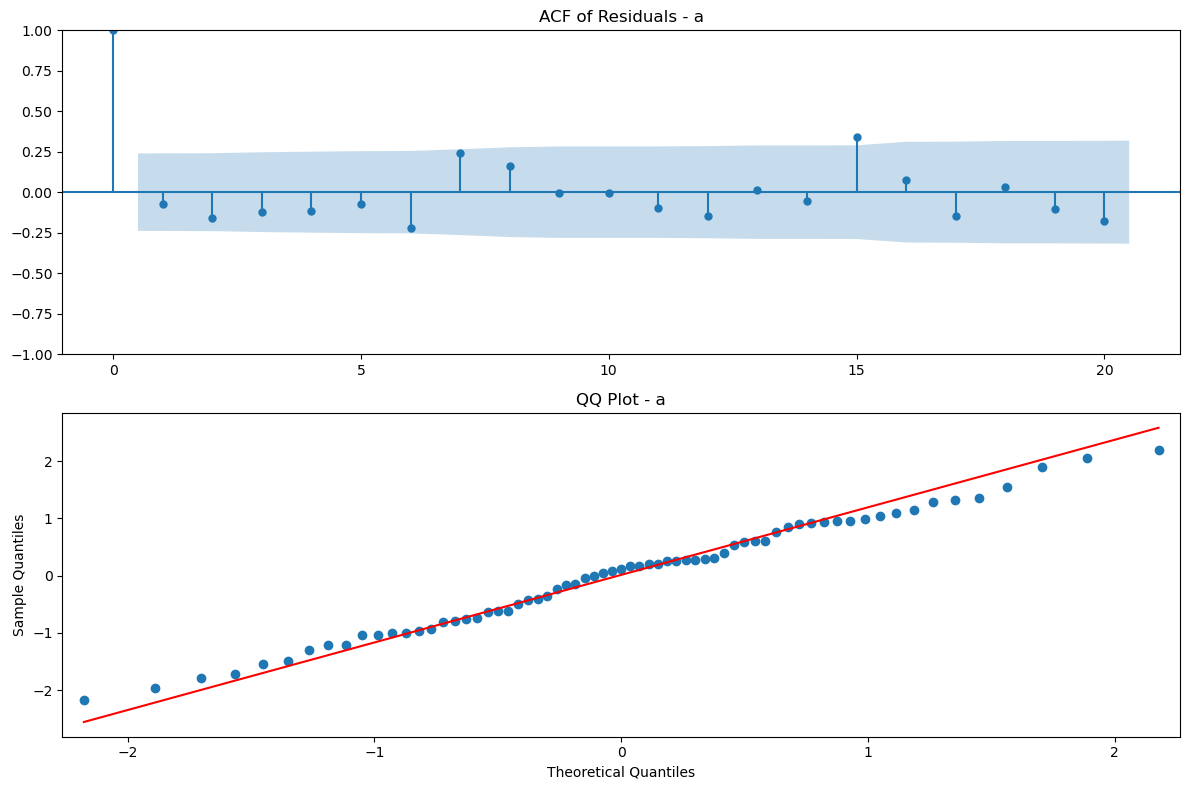

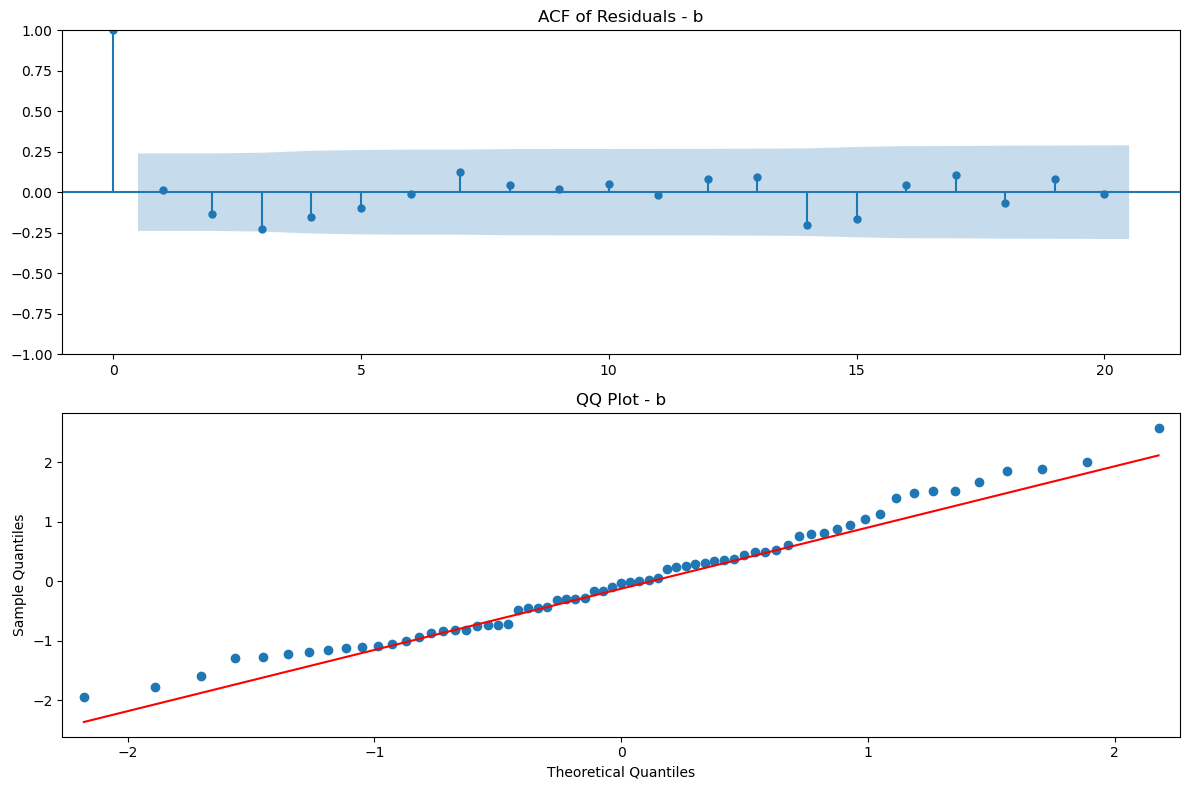

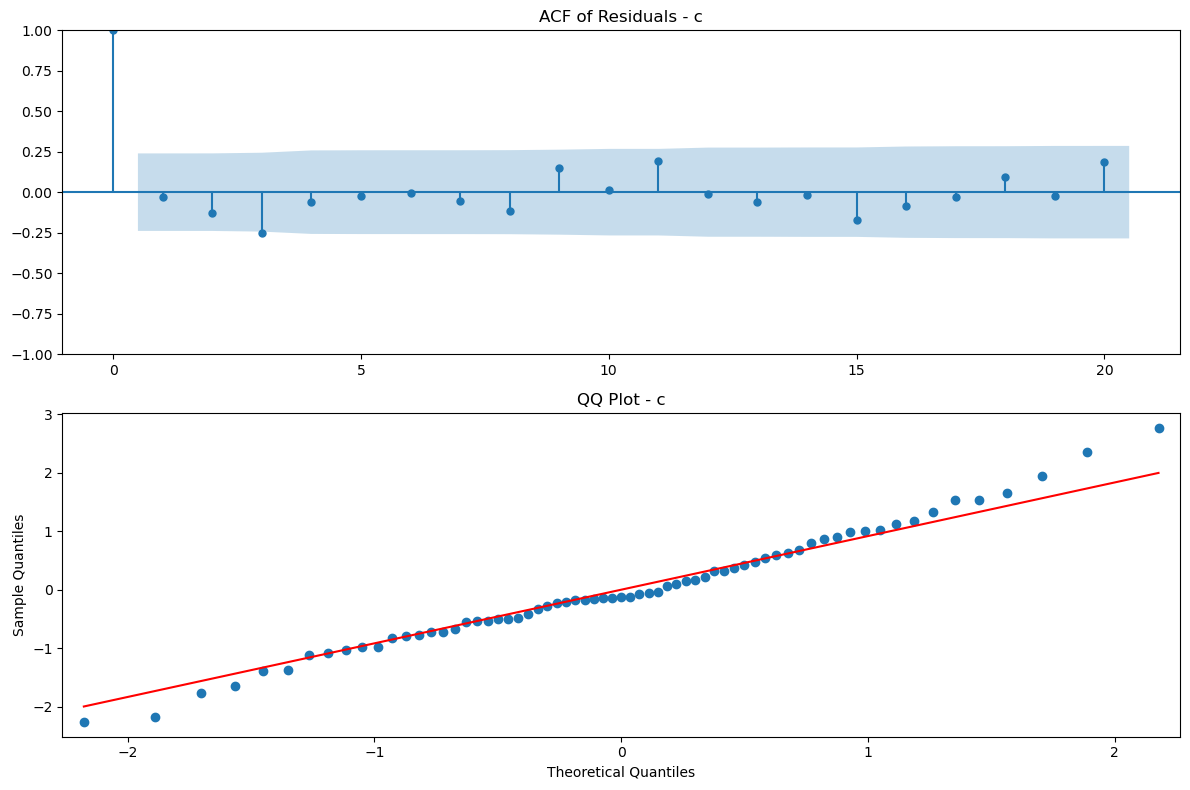


Ljung-Box Test Results:

a:
Lag 1: p-value = 0.0000 (significant)
Lag 2: p-value = 0.0000 (significant)
Lag 3: p-value = 0.0000 (significant)
Lag 4: p-value = 0.0000 (significant)
Lag 5: p-value = 0.0000 (significant)
Lag 6: p-value = 0.0000 (significant)
Lag 7: p-value = 0.0000 (significant)
Lag 8: p-value = 0.0000 (significant)
Lag 9: p-value = 0.0000 (significant)
Lag 10: p-value = 0.0000 (significant)
Lag 11: p-value = 0.0000 (significant)

b:
Lag 1: p-value = 0.0000 (significant)
Lag 2: p-value = 0.0000 (significant)
Lag 3: p-value = 0.0000 (significant)
Lag 4: p-value = 0.0000 (significant)
Lag 5: p-value = 0.0000 (significant)
Lag 6: p-value = 0.0000 (significant)
Lag 7: p-value = 0.0000 (significant)
Lag 8: p-value = 0.0000 (significant)
Lag 9: p-value = 0.0000 (significant)
Lag 10: p-value = 0.0000 (significant)
Lag 11: p-value = 0.0000 (significant)

c:
Lag 1: p-value = 0.0000 (significant)
Lag 2: p-value = 0.0000 (significant)
Lag 3: p-value = 0.0000 (significant)
Lag 4: p-

/home/yxcai/Yuxi/time-series-forecasting/autoregression.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat([predictions, forecast_df], ignore_index=True)


In [24]:
# Simulate data
total_size = 100
# Generate time index
dates = pd.date_range('2020-01-01', periods=total_size)

# Linear trend + noise
linear_trend1 = 0.1 * np.arange(total_size) + np.random.normal(0, 2, total_size)
linear_trend2 = 0.2 * np.arange(total_size) + np.random.normal(0, 1, total_size)
linear_trend3 = 0.3 * np.arange(total_size) + np.random.normal(0, 2, total_size)

non_stationary_df = pd.DataFrame(np.concatenate([np.expand_dims(linear_trend1, 1), np.expand_dims(linear_trend2, 1), 
        np.expand_dims(linear_trend3, 1)], axis=1), 
        index=dates, columns=['a', 'b', 'c'])

df = make_data_stationary(non_stationary_df)

# note that in train_dataset, seq_len / pred_len does not matter
train_dataset = ts_dataset(df, 2, 1, 'train', ['a', 'b', 'c'], scale=True, inverse=True)
train_df = train_dataset.get_dataframe()
scaler = train_dataset.get_scaler()

# fit model
model = fit_VAR(train_df, 2)
# check residuals
diagnostics_checking(model)

# note that for autoregression, we do not use the validation
# hence pool the two together
# seq_len depends on model.k_ar
val_dataset = ts_dataset(df, int(model.k_ar), 1, 'val', ['a', 'b', 'c'], scale=True, inverse=True)
val_df = val_dataset.get_dataframe()

test_dataset = ts_dataset(df, int(model.k_ar), 1, 'test', ['a', 'b', 'c'], scale=True, inverse=True)
test_df = test_dataset.get_dataframe()

# important to drop_duplicates
test_df = pd.concat([val_df, test_df]).drop_duplicates()

non_stationary_test_df = non_stationary_df.loc[non_stationary_df.index.isin(test_df.index)]

forecast_df, forecast_diff_df = forecast(model, non_stationary_test_df, test_df, scaler, 1)

In [25]:
print(forecast_df.head(20))

                    a          b          c  a_forecast  b_forecast  \
2020-03-10   6.861243  13.861683  21.903028    6.861243   13.861683   
2020-03-11   4.535261  13.708871  18.788109    8.319480   12.954244   
2020-03-12   5.994444  14.444845  20.522622   11.301642   14.033934   
2020-03-13   5.306319  13.262527  22.173578   11.160814   13.767472   
2020-03-14   5.599120  14.918414  22.868478   11.703101   14.150574   
2020-03-15   9.377910  14.285046  19.803048   12.077871   14.099479   
2020-03-16   5.322394  14.508268  22.081509    9.387992   14.563965   
2020-03-17   4.413636  15.463147  23.831616   10.735316   14.283868   
2020-03-18   7.765879  15.061265  22.093516   13.826545   14.415072   
2020-03-19   5.676948  16.006493  23.731094   12.068381   14.917159   
2020-03-20   6.752775  17.127286  23.877339   12.405644   14.471851   
2020-03-21   9.748802  16.087262  25.994906   13.212919   14.380708   
2020-03-22  11.565841  14.107025  27.411320   11.220575   14.390714   
2020-0

In [26]:
print(len(test_df))

32


In [27]:
forecast_diff_df

,a,b,c
0,0.491641,-0.753103,-1.069196
1,1.028985,0.620500,0.089159
2,-0.072198,-0.310027,-0.034987
3,0.168672,0.138984,-0.529058
4,0.109604,-0.161155,-0.323250
5,-0.971007,0.195241,1.026104
6,0.452532,-0.319453,-0.177796
7,1.067443,-0.035141,-0.895799
8,-0.642479,0.221233,0.470151
9,0.096379,-0.433655,-0.108537


In [28]:
x = forecast_df.dropna().diff().dropna()
x = x[['a_forecast', 'b_forecast', 'c_forecast']].rename(columns=
                                                         {'a_forecast':'a', 'b_forecast':'b', 'c_forecast':'c'})
x

,a,b,c
2020-03-11,1.458237,-0.907439,-2.624854
2020-03-12,2.982162,1.079689,0.562279
2020-03-13,-0.140828,-0.266461,0.220702
2020-03-14,0.542288,0.383102,-1.138702
2020-03-15,0.374769,-0.051095,-0.572435
2020-03-16,-2.689879,0.464486,3.140219
2020-03-17,1.347324,-0.280097,-0.172230
2020-03-18,3.091230,0.131204,-2.147763
2020-03-19,-1.758164,0.502088,1.610553
2020-03-20,0.337263,-0.445308,0.018333


In [29]:
print(forecast_diff_df)

           a         b         c
0   0.491641 -0.753103 -1.069196
1   1.028985  0.620500  0.089159
2  -0.072198 -0.310027 -0.034987
3   0.168672  0.138984 -0.529058
4   0.109604 -0.161155 -0.323250
5  -0.971007  0.195241  1.026104
6   0.452532 -0.319453 -0.177796
7   1.067443 -0.035141 -0.895799
8  -0.642479  0.221233  0.470151
9   0.096379 -0.433655 -0.108537
10  0.262108 -0.188838 -0.218032
11 -0.725052 -0.118919 -0.313568
12 -0.894435  0.435258 -0.284564
13  0.962616 -0.380892 -0.310919
14 -0.171613 -0.076835  0.148934
15  0.052155  0.097336  0.625911
16  0.768232 -0.354631 -0.729464
17 -0.765376  0.734531  0.863665
18  0.146873 -0.369859  0.772193
19  0.721293  0.374789  0.672155
20 -0.464150 -0.579536 -1.097532
21 -0.028666  0.151998 -0.954395
22 -0.796024  0.090745  0.201647
23  1.045109 -0.694671 -0.861893
24  1.090136  0.181159 -0.454301
25 -1.057240  1.076919  2.069817
26 -1.998169 -0.751776  0.520822
27  1.527472 -0.259368 -0.281930
28  0.285000  0.336110 -0.100085
29 -0.7373

In [30]:
print(scaler.transform(x))

                   a         b         c
2020-03-11  0.491641 -0.753103 -1.069196
2020-03-12  1.028985  0.620500  0.089159
2020-03-13 -0.072198 -0.310027 -0.034987
2020-03-14  0.168672  0.138984 -0.529058
2020-03-15  0.109604 -0.161155 -0.323250
2020-03-16 -0.971007  0.195241  1.026104
2020-03-17  0.452532 -0.319453 -0.177796
2020-03-18  1.067443 -0.035141 -0.895799
2020-03-19 -0.642479  0.221233  0.470151
2020-03-20  0.096379 -0.433655 -0.108537
2020-03-21  0.262108 -0.188838 -0.218032
2020-03-22 -0.725052 -0.118919 -0.313568
2020-03-23 -0.894435  0.435258 -0.284564
2020-03-24  0.962616 -0.380892 -0.310919
2020-03-25 -0.171613 -0.076835  0.148934
2020-03-26  0.052155  0.097336  0.625911
2020-03-27  0.768232 -0.354631 -0.729464
2020-03-28 -0.765376  0.734531  0.863665
2020-03-29  0.146873 -0.369859  0.772193
2020-03-30  0.721293  0.374789  0.672155
2020-03-31 -0.464150 -0.579536 -1.097532
2020-04-01 -0.028666  0.151998 -0.954395
2020-04-02 -0.796024  0.090745  0.201647
2020-04-03  1.04

In [31]:
train_dataset = ts_dataset(df, 2, 1, 'train', ['a', 'b', 'c'], scale=True, inverse=True)
train_df = train_dataset.get_dataframe()

mean:  a    0.063928
b    0.182040
c    0.316964
dtype: float64
std:  a    2.836032
b    1.446654
c    2.751431
dtype: float64


In [32]:
print(train_df.tail(5))

                   a         b         c
2020-03-06  0.403695 -0.420731  1.095587
2020-03-07 -0.303099 -0.771369 -2.518088
2020-03-08  0.029631  0.585613  0.946493
2020-03-09  0.336435 -0.076091 -1.242619
2020-03-10 -0.629936  0.488607  1.861977


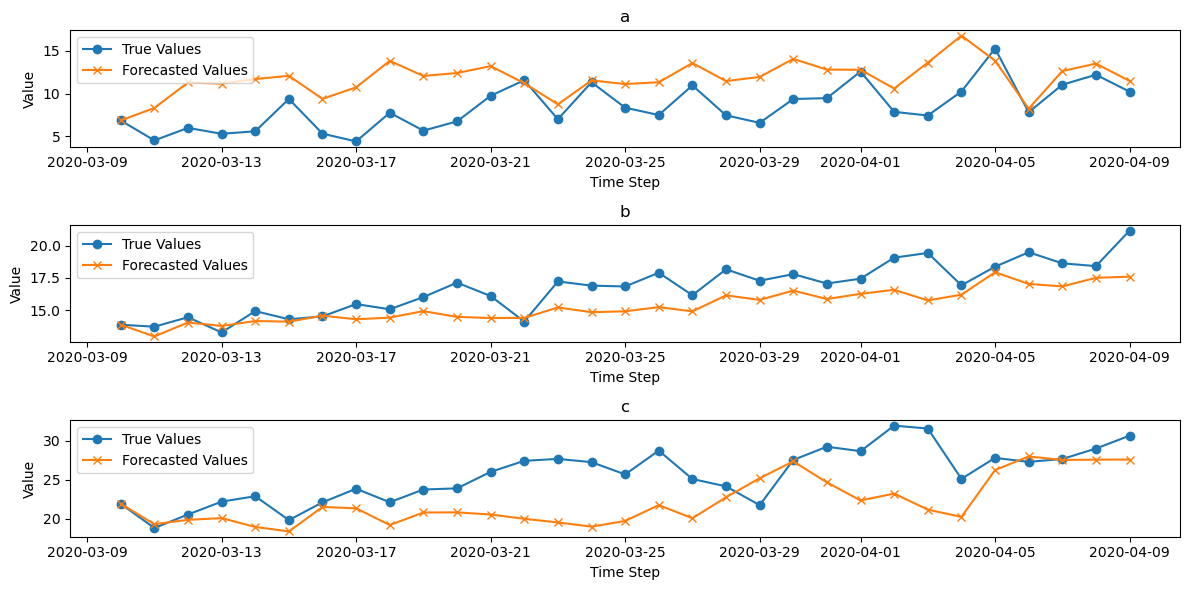

In [33]:
from autoregression import plot_forecast
plot_forecast(forecast_df, target_features=['a', 'b', 'c'])

In [45]:
total_size = 18
np_x = np.arange(3 * total_size).reshape(total_size, 3, order='F')
df = pd.DataFrame(np_x, columns=['a', 'b', 'c'])
print(df)

train_dataset = ts_dataset(df, 2, 1, 'train', ['a', 'b', 'c'], scale=False, inverse=True, train_size=0.8)
train_df = train_dataset.get_dataframe()

val_dataset = ts_dataset(df, 2, 1, 'val', ['a', 'b', 'c'], scale=False, inverse=True,  train_size=0.8)
val_df = val_dataset.get_dataframe()

test_dataset = ts_dataset(df, 2, 1, 'test', ['a', 'b', 'c'], scale=False, inverse=True,  train_size=0.8)
test_df = test_dataset.get_dataframe()


test_df = pd.concat([val_df, test_df], axis=0)

     a   b   c
0    0  18  36
1    1  19  37
2    2  20  38
3    3  21  39
4    4  22  40
5    5  23  41
6    6  24  42
7    7  25  43
8    8  26  44
9    9  27  45
10  10  28  46
11  11  29  47
12  12  30  48
13  13  31  49
14  14  32  50
15  15  33  51
16  16  34  52
17  17  35  53


In [46]:
print(train_df)

     a   b   c
0    0  18  36
1    1  19  37
2    2  20  38
3    3  21  39
4    4  22  40
5    5  23  41
6    6  24  42
7    7  25  43
8    8  26  44
9    9  27  45
10  10  28  46
11  11  29  47
12  12  30  48
13  13  31  49


In [47]:
print(test_df)

     a   b   c
12  12  30  48
13  13  31  49
14  14  32  50
13  13  31  49
14  14  32  50
15  15  33  51
16  16  34  52
17  17  35  53


In [48]:
train_df.diff()

,a,b,c
0,NaN,NaN,NaN
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
5,1.0,1.0,1.0
6,1.0,1.0,1.0
7,1.0,1.0,1.0
8,1.0,1.0,1.0
9,1.0,1.0,1.0


In [49]:
'''
window_size = 2

0  
1
2
3
4
5


1 - 0
2 - 1
3 - 2      x                
4 - 3      x
5 - 4      x

i in [0,1,2]


3-2     3
4-2     4    
5-2     5 

1
2
3
4
5



'''


'\nwindow_size = 2\n\n0  \n1\n2\n3\n4\n5\n\n\n1 - 0\n2 - 1\n3 - 2      x                \n4 - 3      x\n5 - 4      x\n\ni in [0,1,2]\n\n\n3-2     3\n4-2     4    \n5-2     5 \n\n1\n2\n3\n4\n5\n\n\n\n'